In [1]:
import pandas as pd
import numpy as np


from neuralforecast import NeuralForecast
from neuralforecast.models import (
    NBEATS,
    NHITS,
    TFT)

from statsforecast.core import StatsForecast
from neuralforecast.auto import AutoMLP, AutoDeepAR, AutoNBEATS, AutoNHITS, AutoTFT , AutoDeepNPTS
from statsforecast.models import (
    Naive,
    SeasonalNaive,
    ARIMA,
    SimpleExponentialSmoothing,
    ETS,
    HistoricAverage,
    WindowAverage,
    AutoARIMA,
    AutoETS,
    AutoCES,
    AutoTheta
)

# Naive
# Naive season
# Seasonal Arima (0,1 1)( 0,1,1)

from mlforecast import MLForecast
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
from mlforecast.target_transforms import Differences
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from numba import njit
from window_ops.rolling import rolling_mean


import plotly.graph_objects as go


In [2]:
# Function to evaluate forecasts
def evaluate_forecast(y_true, y_pred):
    return np.sqrt(np.mean((y_true.values - y_pred.values) ** 2))

def calculate_error(test,forecast):
    error_dict={}
    for col in forecast.columns:
        if (col == 'ds') | (col == 'unique_id'):
            continue
        else: 
            error_dict.update({col:evaluate_forecast(test['y'],forecast[col])})
    return pd.DataFrame(error_dict,index=['Error'])

In [3]:

from statsforecast.utils import AirPassengersDF

# Load the AirPassengers dataset
df = AirPassengersDF


# Train-test split
test_size = 24
train_size = len(df) - test_size
train, test = df[:train_size], df[train_size:]


df.to_csv('Air_passengers.csv')

In [4]:
models = [
    Naive(),
    SeasonalNaive(12),
    ARIMA(order=[12,1,0]),
    ARIMA(order=[0,1,1], seasonal_order=[0,1,1], season_length=12 ,alias='SARIMA'),
    SimpleExponentialSmoothing(alpha=0.28),
    ETS(model='ZZZ',season_length=12),
    HistoricAverage(),
    WindowAverage(window_size=6)
]

sf = StatsForecast( 
    models=models,
    freq='ME', 
    n_jobs=-1,
)

forecasts_df = sf.forecast(df=train, h=test_size)
# forecasts_df.head()
error_non_auto = calculate_error(test,forecasts_df) 

c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\statsforecast\models.py:880: FutureWarning: `ETS` will be deprecated in future versions of `StatsForecast`. Please use `AutoETS` instead.
  ETS._warn()
c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\statsforecast\core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [5]:
error_non_auto

,Naive,SeasonalNaive,ARIMA,SARIMA,SES,ETS,HistoricAverage,WindowAverage
Error,137.328985,76.994589,97.23538,71.892014,112.488931,78.373247,219.439212,90.571795


In [6]:
models = [
    AutoARIMA(max_p=12),
    AutoETS(season_length=12),
    AutoCES(season_length=12,alias='AutoCES'),
    AutoTheta(season_length=12)
]

sf = StatsForecast( 
    models=models,
    freq='ME', 
    n_jobs=-1,
)

forecasts_df_auto = sf.forecast(df=train, h=test_size)
error_auto = calculate_error(test,forecasts_df_auto)


c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\statsforecast\core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [9]:
error_auto

,AutoARIMA,AutoETS,AutoCES,AutoTheta
Error,98.313997,78.373247,22.090108,58.674839


In [7]:
@njit
def rolling_mean_12(x):
    return rolling_mean(x, window_size=12)


def month_index(times):
    return times.month

In [8]:
lgb_params = {'verbosity': -1,'num_leaves': 512,}

catboost_params ={'subsample': 0.6 , 'iterations': 50, 'depth': 5, 'verbose':0}

xgboost_params ={'verbosity':0, 'max_depth':5 , 'subsample': 0.6}

randomforest_params = {'verbose': 0, 'max_depth': 5}

fcst = MLForecast(
    models={
        'LightGBM': lgb.LGBMRegressor(**lgb_params),
        'CatBoost': CatBoostRegressor(**catboost_params),
        'XgBoost': XGBRegressor(**xgboost_params),
        'RandomForest': RandomForestRegressor(**randomforest_params)
    },
    freq="ME",
    target_transforms=[Differences([12])],    
    lags= [1,2,3,4,11,12],
    lag_transforms={
        1: [ExpandingMean()],
        12: [RollingMean(window_size=12), rolling_mean_12],
    },
    date_features=[month_index],
)
prep = fcst.preprocess(train)
fcst.fit(train)
forecasts_df_tree = fcst.predict(test_size)
error_tree = calculate_error(test,forecasts_df_tree)



In [10]:
error_tree

,LightGBM,CatBoost,XgBoost,RandomForest
Error,58.164788,24.999375,21.657209,33.989005


In [11]:
from ray import tune
models = [
NBEATS(input_size=2 * test_size, h=test_size, max_steps=50, ),
# NHITS(input_size=2 * test_size, h=test_size, max_steps=50, ),

# AutoMLP(config=dict(max_steps=50, input_size=tune.choice([3*test_size]), # type: ignore
#                               learning_rate=tune.choice([1e-3])), h=test_size,num_samples=1, cpus=3),

# AutoDeepAR(config=dict(max_steps=10, input_size=tune.choice([3*test_size]),
#                               learning_rate=tune.choice([1e-3])), h=test_size,num_samples=1, cpus=3),

# AutoNBEATS(config=dict(max_steps=50, input_size=tune.choice([3*test_size]),
#                               learning_rate=tune.choice([1e-3])), h=test_size,num_samples=1, cpus=3),

# AutoNHITS(config=dict(max_steps=50, input_size=tune.choice([3*test_size]),
#                               learning_rate=tune.choice([1e-3])), h=test_size,num_samples=1, cpus=3),  

# AutoTFT(config=dict(max_steps=50, input_size=tune.choice([3*test_size]),
#                               learning_rate=tune.choice([1e-3])), h=test_size,num_samples=1, cpus=3),  

# AutoDeepNPTS(config=dict(max_steps=50, input_size=tune.choice([3*test_size]),
#                               learning_rate=tune.choice([1e-3])), h=test_size,num_samples=1, cpus=3),           
          ]

#AutoMLP, AutoDeepAR, AutoNBEATS, AutoNHITS, AutoTFT , AutoDeepNPTS
nf = NeuralForecast(models=models, freq='M')

nf.fit(df=train,)
forecasts_df_neural = nf.predict().reset_index()

error_neural = calculate_error(test,forecasts_df_neural)


Seed set to 1
c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\neuralforecast\common\_base_model.py:208: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.5 M 
-----------------------------------------------
2.5 M     Trainable params
3.5 K     Non-trainable params
2.5 M     Total params
10.120    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=50` reached.
c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\utilsforecast\processing.py:374: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\utilsforecast\processing.py:428: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\neuralforecast\core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [12]:
error_neural

,NBEATS
Error,24.693348


In [13]:
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(
    api_key = 'nixtla-tok-BWWtvgUP9FLtzerA90xyzXPvRUoZvA0OYYp5cuSI7NZUyApQjlINlF8dAyYXqDyxWlTlCOg7jXHWJV4o'
)


In [14]:
forecasts_df_timegpt = nixtla_client.forecast(df=train, h=test_size, freq='M', time_col='ds', target_col='y')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: ME
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [15]:
error_timegpt = calculate_error(test,forecasts_df_timegpt)

In [17]:
error_timegpt

,TimeGPT
Error,63.562676


In [57]:
df_timegpt = pd.DataFrame(error_timegpt)
df_neural = pd.DataFrame(error_neural)
df_tree = pd.DataFrame(error_tree)
df_auto = pd.DataFrame(error_auto)
df_non_auto = pd.DataFrame(error_non_auto)


combined_df = pd.concat([df_timegpt, df_neural, df_tree, df_auto, df_non_auto], ignore_index=True)

# Sort the DataFrame by the 'Error' column
sorted_df = combined_df.melt(var_name='Model',value_name='Error').dropna().sort_values(by='Error')

# Reset the index for a cleaner look
sorted_df.reset_index(drop=True, inplace=True)


sorted_df


,Model,Error
0,AutoCES,14.614430
1,TimeGPT,14.626544
2,LightGBM,15.084608
3,XgBoost,15.988342
4,CatBoost,16.557368
5,RandomForest,16.696631
6,SARIMA,20.981510
7,AutoTheta,24.985179
8,ARIMA,26.448005
9,AutoMLP,26.934753


In [58]:
sf.plot(df,forecasts_df,engine='plotly')

c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\statsforecast\core.py:1386: FutureWarning:

Passing the ids as the index is deprecated. Please provide them as a column instead.



In [63]:
sf.plot(df,forecasts_df_auto,engine='plotly')


c:\Users\91976\Desktop\Forecast_llm_comparison\.env\lib\site-packages\statsforecast\core.py:1386: FutureWarning:

Passing the ids as the index is deprecated. Please provide them as a column instead.



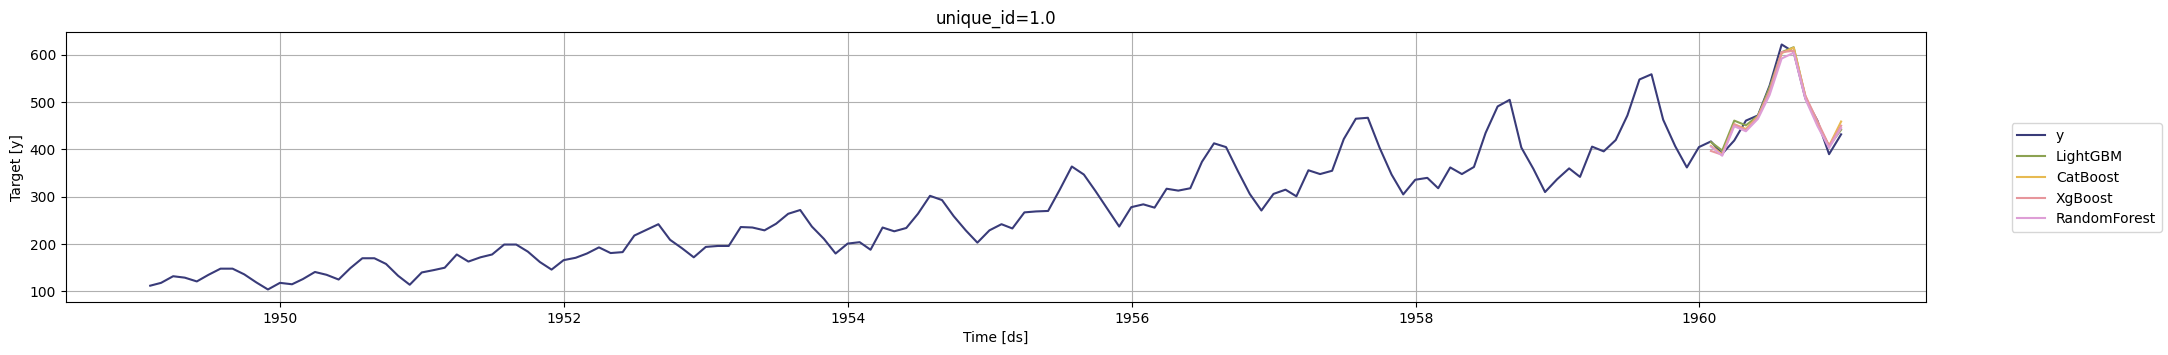

In [60]:
sf.plot(df,forecasts_df_tree.reset_index())


In [64]:
sf.plot(df,forecasts_df_neural,engine='plotly')


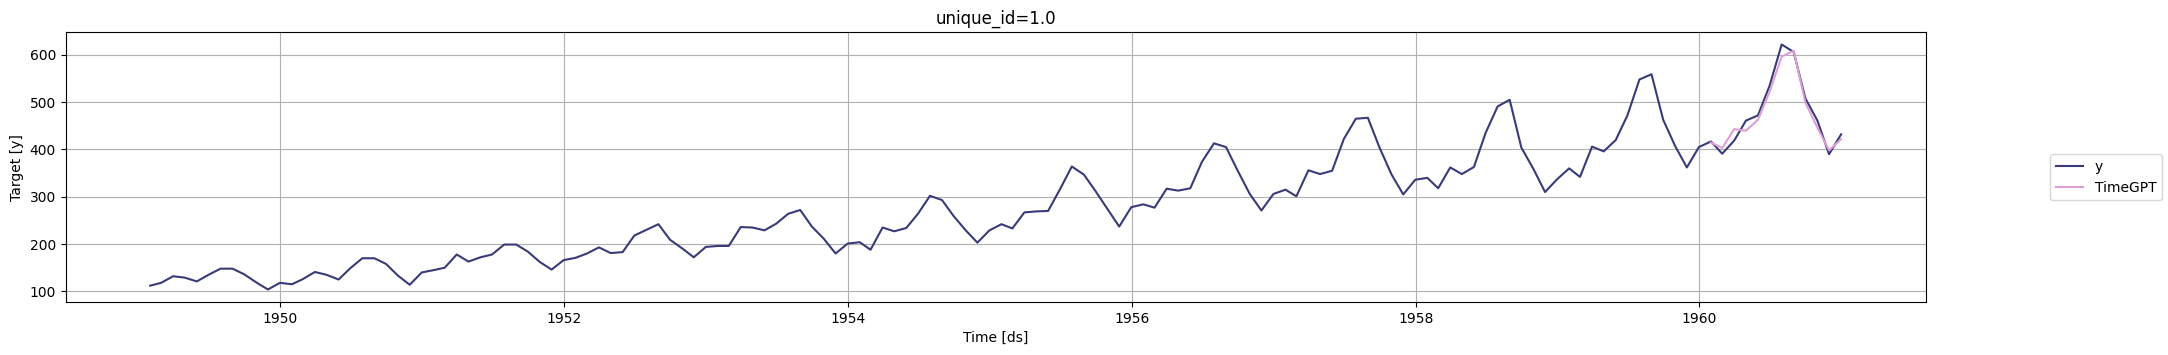

In [62]:
sf.plot(df,forecasts_df_timegpt)
